# Lab 9 MFCC
由於執行.py檔在實驗時遇到了不少麻煩，因此我決定把他們全部移到notebook中執行。
## 各函數的定義

In [1]:
import numpy as np

def pre_emphasis(signal, coefficient = 0.95):

    return np.append(signal[0], signal[1:] - coefficient*signal[:-1])

def STFT(time_signal, num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False):
    padding_length = int((num_frames - 1) * frame_step + frame_length)
    padding_zeros = np.zeros((padding_length - signal_length,))
    padded_signal = np.concatenate((time_signal, padding_zeros))

    # split into frames
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames*frame_step, frame_step), (frame_length, 1)).T
    indices = np.array(indices,dtype=np.int32)

    # slice signal into frames
    frames = padded_signal[indices]
    # apply window to the signal
    frames *= np.hamming(frame_length)

    # FFT
    complex_spectrum = np.fft.rfft(frames, num_FFT).T
    print(complex_spectrum.shape)
    absolute_spectrum = np.abs(complex_spectrum)
    
    if verbose:
        print('Signal length :{} samples.'.format(signal_length))
        print('Frame length: {} samples.'.format(frame_length))
        print('Frame step  : {} samples.'.format(frame_step))
        print('Number of frames: {}.'.format(len(frames)))
        print('Shape after FFT: {}.'.format(absolute_spectrum.shape))

    return absolute_spectrum

def mel2hz(mel):
    '''
    Transfer Mel scale to Hz scale
    '''
    hz = 700 * (10**(mel/2595) - 1)

    return hz

def hz2mel(hz):
    '''
    Transfer Hz scale to Mel scale
    '''
    mel = 2595 * np.log10(1 + hz/700) 

    return mel

def get_filter_banks(num_filters, num_FFT, sample_rate, freq_min = 0, freq_max = None):
    ''' Mel Bank
    num_filters: filter numbers
    num_FFT: number of FFT quantization values
    sample_rate: as the name suggests
    freq_min: the lowest frequency that mel frequency include
    freq_max: the Highest frequency that mel frequency include
    '''
    # convert from hz scale to mel scale
    low_mel = hz2mel(freq_min)
    high_mel = hz2mel(freq_max)

    # define freq-axis
    mel_freq_axis = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_freq_axis = mel2hz(mel_freq_axis)

    # Mel triangle bank design (Triangular band-pass filter banks)
    bins = np.floor((num_FFT + 1) * hz_freq_axis / sample_rate)
    fbanks = np.zeros((num_filters, int(num_FFT / 2 + 1)))
    
    for m in range(1, num_filters + 1): # 三角形
        f_m_minus = int(bins[m - 1])   # 左
        f_m = int(bins[m])             # 中
        f_m_plus = int(bins[m + 1])    # 右

        for k in range(f_m_minus, f_m):
            fbanks[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbanks[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])
            
    return fbanks

## 引入所需的package

In [2]:
'''
@Modified by Paul Cho; 10th, Nov, 2020

For NTHU DSP Lab 2020 Autumn
'''
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from librosa.filters import mel as librosa_mel_fn
from scipy.fftpack import dct
#from Lab9_functions_student import pre_emphasis, STFT, mel2hz, hz2mel, get_filter_banks

## 繪製STFT

Sampling rate=22050 Hz.
(257, 552)
(257, 552)
(257, 552)
(257, 552)


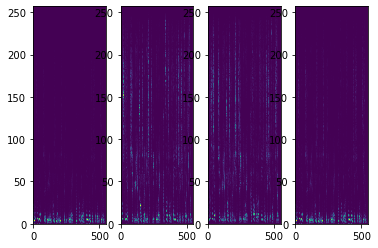

In [7]:
filename = './audio.wav'
source_signal, sr = sf.read(filename) #sr:sampling rate
print('Sampling rate={} Hz.'.format(sr))

### hyper parameters
frame_length = 512                    # Frame length(samples)
frame_step = 256                      # Step length(samples)
emphasis_coeff = 0.95                 # pre-emphasis para
num_bands = 12                        # Filter number = band number
num_FFT = frame_length                # FFT freq-quantization
freq_min = 0
freq_max = int(0.5 * sr)
signal_length = len(source_signal)    # Signal length

# number of frames it takes to cover the entirety of the signal
num_frames = 1 + int(np.ceil((1.0 * signal_length - frame_length) / frame_step))

##########################
'''
Part I:
(1) Perform STFT on the source signal to obtain one spectrogram (with the provided STFT() function)
(2) Pre-emphasize the source signal with pre_emphasis()
(3) Perform STFT on the pre-emphasized signal to obtain the second spectrogram
(4) Plot the two spectrograms together to observe the effect of pre-emphasis

hint for plotting:
you can use "plt.subplots()" to plot multiple figures in one.
you can use "axis.pcolor" of matplotlib in visualizing a spectrogram. 
'''

# 依照不同的alpha值繪製時頻譜
stft = STFT(source_signal, num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False)
enph_signal_95 = pre_emphasis(source_signal, 0.95)
enph_signal_99 = pre_emphasis(source_signal, 0.99)
enph_signal_65 = pre_emphasis(source_signal, 0.65)
enph_stft_95 = STFT(enph_signal_95, num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False)
enph_stft_99 = STFT(enph_signal_99, num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False)
enph_stft_65 = STFT(enph_signal_65, num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False)

fig, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(1,4) #繪圖
ax_1.pcolor(stft)
ax_2.pcolor(enph_stft_95)
ax_3.pcolor(enph_stft_99)
ax_4.pcolor(enph_stft_65)
plt.savefig("STFT.png",dpi=500)
plt.show()

## 繪製filter bank
我們只取前12個係數，所以是12個filter

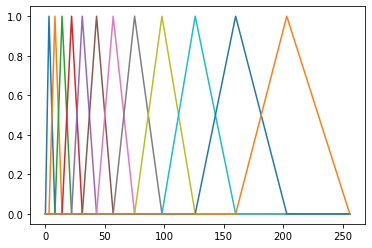

In [17]:
##########################

'''
Head to the import source 'Lab9_functions_student.py' to complete these functions:
mel2hz(), hz2mel(), get_filter_banks()
'''
# get Mel-scaled filter
fbanks = get_filter_banks(num_bands, num_FFT , sr, freq_min, freq_max)
plt.plot(np.arange(np.size(fbanks[1])), fbanks.T)
plt.savefig("12_filter_bank.png",dpi=500)
plt.show()
##########################

檢查一下STFT矩陣與filter bank的大小，等等做filting才不會乘錯人。

In [6]:
print(fbanks.shape)
print(stft.shape)

(12, 257)
(257, 552)


## 計算MFCC並繪製heat map

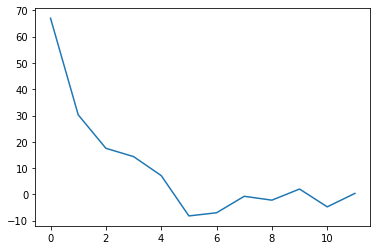

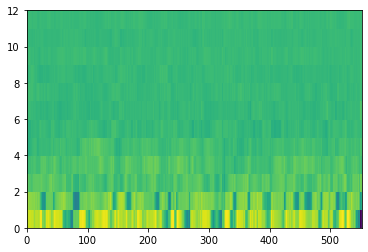

In [18]:
'''
Part II:
(1) Convolve the pre-emphasized signal with the filter
(2) Convert magnitude to logarithmic scale
(3) Perform Discrete Cosine Transform (dct) as a process of information compression to obtain MFCC
    (already implemented for you, just notice this step is here and skip to the next step)
(4) Plot the filter banks alongside the MFCC
'''

features = np.dot(stft.T,fbanks.T) # (1) Convolve the pre-emphasized signal with the filter
features = 20 * np.log10(features) # (2) Convert magnitude to logarithmic scale

# (3) Discrete Cosine Transform
MFCC = dct(features, norm = 'ortho')[:,:num_bands]
# equivalent to Matlab dct(x)
# The numpy array [:,:] stands for everything from the beginning to end.

plt.plot(np.arange(12), MFCC[50]) # Plot the MFCC的摺線圖 of 第50個frame
plt.savefig("12_coeff.png",dpi=500)
plt.show()

fig, (ax_1) = plt.subplots(1,1) # 繪製MFCC heat map
ax_1.pcolor(MFCC.T)
plt.savefig("12_heatmap.png",dpi=500)
plt.show()

#YOUR CODE ENDS HERE;
##########################

## 取60個MFCC係數
比較其結果與只取12個係數的差異

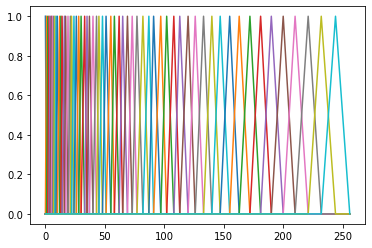

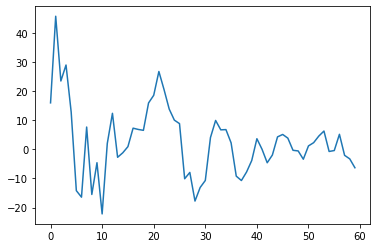

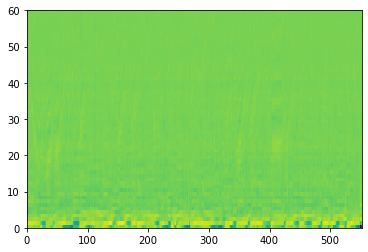

In [19]:
fbanks = get_filter_banks(60, num_FFT , sr, freq_min, freq_max)
plt.plot(np.arange(np.size(fbanks[1])), fbanks.T)
plt.savefig("60_filter_bank.png",dpi=500)
plt.show()

features = np.dot(stft.T,fbanks.T) # Convolve the pre-emphasized signal with the filter
features = 20 * np.log10(features) # Convert magnitude to logarithmic scale
MFCC = dct(features, norm = 'ortho')[:,:60] # Discrete Cosine Transform

plt.plot(np.arange(60), MFCC[50])
plt.savefig("60_coeff.png",dpi=500)
plt.show()

plt.show()
fig, (ax_1) = plt.subplots(1,1)
ax_1.pcolor(MFCC.T)
plt.savefig("60_heatmap.png",dpi=500)
plt.show()

## Bonus: FFT係數數量探討
重新定義一個STFT_conventional函數，與STFT()唯一的差異在於使用np.fft.fft()。

In [20]:
def STFT_conventional(time_signal, num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False):
    padding_length = int((num_frames - 1) * frame_step + frame_length)
    padding_zeros = np.zeros((padding_length - signal_length,))
    padded_signal = np.concatenate((time_signal, padding_zeros))

    # split into frames
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames*frame_step, frame_step), (frame_length, 1)).T
    indices = np.array(indices,dtype=np.int32)

    # slice signal into frames
    frames = padded_signal[indices]
    # apply window to the signal
    frames *= np.hamming(frame_length)

    # FFT
    complex_spectrum = np.fft.fft(frames, num_FFT).T # Only different here
    print(complex_spectrum.shape)
    absolute_spectrum = np.abs(complex_spectrum)
    
    if verbose:
        print('Signal length :{} samples.'.format(signal_length))
        print('Frame length: {} samples.'.format(frame_length))
        print('Frame step  : {} samples.'.format(frame_step))
        print('Number of frames: {}.'.format(len(frames)))
        print('Shape after FFT: {}.'.format(absolute_spectrum.shape))

    return absolute_spectrum


同時畫兩張時頻譜以進行比較

(512, 552)


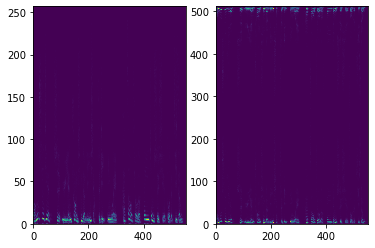

In [22]:
# 對原訊號進行普通的FFT
stft2 = STFT_conventional(source_signal, num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False)

fig, (ax_1, ax_2) = plt.subplots(1,2)
ax_1.pcolor(stft)
ax_2.pcolor(stft2)
plt.savefig("STFT_compare.png",dpi=500)
plt.show()